## Import some helpful libraries

In [30]:
## Import some helpful libraries
print("    Version control\n------------------------")
import os, fnmatch, random, math, sys, datetime
from pathlib import Path
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras;                    print("Keras\t\t {}".format(keras.__version__))
import tensorflow.keras.backend as K
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D, ZeroPadding3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
# import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from scipy.cluster import hierarchy
# from scipy.cluster.hierarchy import dendrogram, linkage
# import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
# import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
# from nibabel.testing import data_path
# %load_ext tensorboard       
# %reload_ext tensorboard

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
Pandas		 1.1.4
H5py		 2.10.0
TensorFlow	 2.4.0
Keras		 2.4.3


## Dataset

In [31]:
## Load all data
sample_name = np.loadtxt(('../Data/data_random_1/raw_data/all_sample_name.csv'), dtype=str, delimiter=",")
all_data = np.load('../Data/data_random_1/raw_data/all.npy').reshape(124,182,218,182,1)
print('all_data shape is {}'.format(all_data.shape))

## Padding datasets
all_pad_data = (ZeroPadding3D(padding=(5,19,5))(all_data)).numpy()
print('all_padded_data shape is {}'.format(all_pad_data.shape))

all_data shape is (124, 182, 218, 182, 1)
all_padded_data shape is (124, 192, 256, 192, 1)


In [32]:
## Show the list of files
print("samThere are", len(sample_name), " subset of train samples are:\n")
print(*sample_name, sep='\t')

samThere are 124  subset of train samples are:

Pat_100_1-post.nii.gz	Pat_101_1-post.nii.gz	Pat_102_1-post.nii.gz	Pat_103_1-post.nii.gz	Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_109_1-post.nii.gz	Pat_10_1-post.nii.gz	Pat_110_1-post.nii.gz	Pat_113_1-post.nii.gz	Pat_114_1-post.nii.gz	Pat_115_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_117_1-post.nii.gz	Pat_118_1-post.nii.gz	Pat_11_1-post.nii.gz	Pat_121_1-post.nii.gz	Pat_122_1-post.nii.gz	Pat_123_1-post.nii.gz	Pat_125_1-post.nii.gz	Pat_126_1-post.nii.gz	Pat_127_1-post.nii.gz	Pat_128_1-post.nii.gz	Pat_129_1-post.nii.gz	Pat_12_1-post.nii.gz	Pat_130_1-post.nii.gz	Pat_131_1-post.nii.gz	Pat_132_1-post.nii.gz	Pat_135_1-post.nii.gz	Pat_137_1-post.nii.gz	Pat_138_1-post.nii.gz	Pat_139_1-post.nii.gz	Pat_13_1-post.nii.gz	Pat_140_1-post.nii.gz	Pat_141_1-post.nii.gz	Pat_142_1-post.nii.gz	Pat_143_1-post.nii.gz	Pat_144_1-post.nii.gz	Pat_145_1-post.nii.gz	Pat_14_1-post.nii.gz	Pat_15_1-post.nii.gz	Pat_16_1-post.nii.gz	Pat_17_1-post.nii.gz	Pat_18_1-post.

## Showing slices

In [33]:
## Main Function
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray

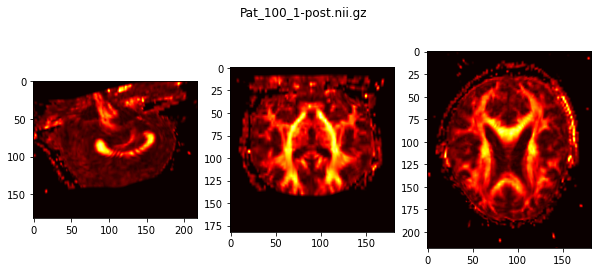

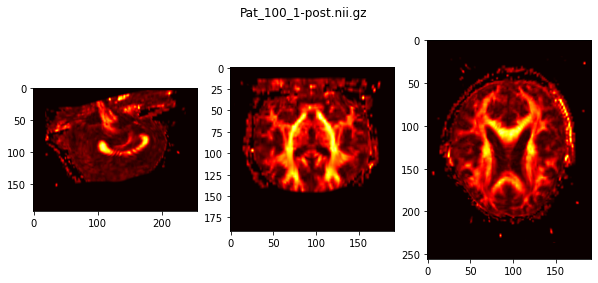

In [34]:
## Showing Original All samples
for m in range(1):
    slice_0 = all_data[m, 91, :, :, 0]
    slice_1 = all_data[m, :, 109, :, 0]
    slice_2 = all_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_name[m], x=0.5, y=0.9)

## Showing Padded All samples
for m in range(1):
    slice_3 = all_pad_data[m, 96, :, :, 0]
    slice_4 = all_pad_data[m, :, 128, :, 0]
    slice_5 = all_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
    plt.suptitle(sample_name[m], x=0.5, y=0.9)

## Model design

In [35]:
## Convolutional AutoEncoder Model Designe:

BATCH_SIZE = 1
EPOCHS = 1

IMAGE_HEIGHT = all_pad_data.shape[1]
IMAGE_WIDTH  = all_pad_data.shape[2]
IMAGE_DEPTH  = all_pad_data.shape[3]
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("Padded data shape: {}\n".format(input_shape))

## Encoder
input_img = Input(shape=(192, 256, 192, 1), name='Input')
x1 = Conv3D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x1 = BatchNormalization(name='BN_Conv1')(x1)
x2 = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x1)
x2 = BatchNormalization(name='BN_Conv2')(x2)
x3 = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x2)
x3 = BatchNormalization(name='BN_Conv3')(x3)
x4 = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv4')(x3)
x4 = BatchNormalization(name='BN_Conv4')(x4)

## Latent Features
shape_before_flattening = tf.keras.backend.int_shape(x4)
x_LF = Flatten(name='LF')(x4)
encoded = x_LF
x5 = Reshape(shape_before_flattening[1:], name='UnFlat')(encoded)

## Decoder
x5 = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu', name='DeConv3')(x5)
x5 = BatchNormalization(name='BN_DeConv3')(x5)
x5 = UpSampling3D(size=(2, 2, 2), name='UpSampling3')(x5)
x6 = Conv3D(filters=32, kernel_size=3, padding='same', activation='relu', name='DeConv4')(x5)
x6 = BatchNormalization(name='BN_DeConv4')(x6)
x6 = UpSampling3D(size=(2, 2, 2), name='UpSampling4')(x6)
x7 = Conv3D(filters=64, kernel_size=3, padding='same', activation='relu', name='DeConv5')(x6)
x7 = BatchNormalization(name='BN_DeConv5')(x7)
x7 = UpSampling3D(size=(2, 2, 2), name='UpSampling5')(x7)
x8 = Conv3D(filters=128, kernel_size=3, padding='same', activation='relu', name='DeConv6')(x7)
x8 = BatchNormalization(name='BN_DeConv6')(x8)
x8 = UpSampling3D(size=(2, 2, 2), name='UpSampling6')(x8)
decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x8)

model_CAE = Model(inputs=input_img, outputs=decoded, name='AutoEncoder')
## optimizer=rmsprop, sgd
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()
# plot_model(model_CAE, to_file='Convolutional_autoencoder_model.png', show_shapes=True)
# Image(filename='Convolutional_autoencoder_model.png')

Padded data shape: [1, 192, 256, 192, 1]

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 192, 256, 192, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 96, 128, 96, 128)  3584      
_________________________________________________________________
BN_Conv1 (BatchNormalization (None, 96, 128, 96, 128)  512       
_________________________________________________________________
Conv2 (Conv3D)               (None, 48, 64, 48, 64)    221248    
_________________________________________________________________
BN_Conv2 (BatchNormalization (None, 48, 64, 48, 64)    256       
_________________________________________________________________
Conv3 (Conv3D)               (None, 24, 32, 24, 32)    55328     
_________________________________________________________________
BN_Conv3 (Bat

## Model training

In [73]:
## Start time:
# from datetime import datetime
# start_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nStart Time =", start_time, "\n")

## Model Fit
# model_CAE.load_weights('./Weights/HPC2_T124_e500___2021_02_20___21_39.hdf5', by_name=True)  # Train_124 e500 
# model_CAE.load_weights('./Weights/HPC2_T124_e1500___2021_02_21___16_34.hdf5', by_name=True) # Train_124 e1500
# model_CAE.load_weights('./Weights/Step_0_2021_02_21___05_02.hdf5', by_name=True)   # Train_124 Cross_oute_0.2 e500 Step_0
# model_CAE.load_weights('./Weights/Step_1_2021_02_21___18_10.hdf5', by_name=True)   # Train_124 Cross_oute_0.2 e500 Step_1
# model_CAE.load_weights('./Weights/Step_2_2021_02_23___19_32.hdf5', by_name=True)   # Train_124 Cross_oute_0.2 e500 Step_2
# model_CAE.load_weights('./Weights/Step_3_2021_02_24___10_26.hdf5', by_name=True)   # Train_124 Cross_oute_0.2 e500 Step_3
# model_CAE.load_weights('./Weights/Step_4_2021_02_24___23_21.hdf5', by_name=True)   # Train_124 Cross_oute_0.2 e500 Step_4

# tb_callback = TensorBoard(('./Logs/all___' + start_time), histogram_freq=1)
# model_CAE.fit(all_pad_data, all_pad_data, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback], verbose=1)
# model_CAE.fit(train_pad_data, train_pad_data, validation_data=(valid_pad_data, valid_pad_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.save_weights('./Weights/all___' + start_time + '.hdf5')

## End time:
# from datetime import datetime
# end_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nEnd Time =", end_time)

## Image reconstruction

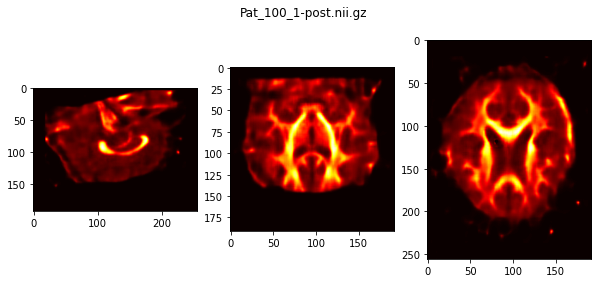

In [9]:
# All 124 training with no validation for 500 epochs
HPC2_T124_e500___2021_02_20___21_39

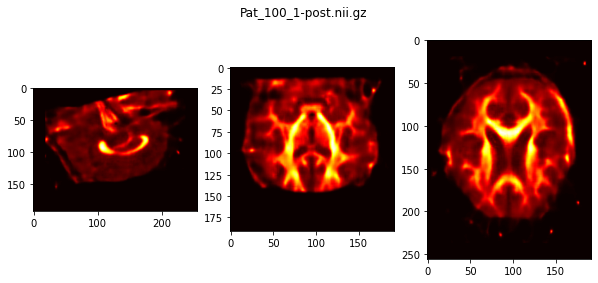

In [37]:
# All 124 training with no validation for 1500 epochs
HPC2_T124_e1500___2021_02_21___16_34

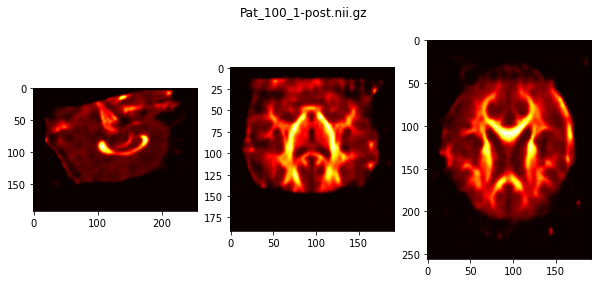

In [72]:
## All 124 for train with 20% cross out (Step 0) 
Step_0_2021_02_21___05_02

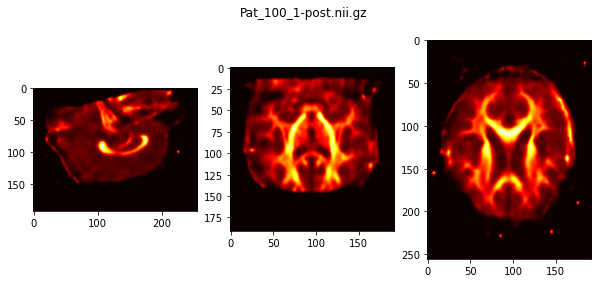

In [74]:
## All 124 for train with 20% cross out (Step 4) 
Step_4_2021_02_24___23_21

In [ ]:
## Reconstructing a Train data 
test_pad_data = all_pad_data[0,:].reshape(1, 192, 256, 192, 1)
# ## Reconstructing a Valid data 
# test_pad_data = valid_pad_data[0,:].reshape(1, 192, 256, 192, 1)

reconstructed = model_CAE.predict(test_pad_data)
for m in range(1):
    slice_0 = reconstructed[m, 96, :, :, 0]
    slice_1 = reconstructed[m, :, 128, :, 0]
    slice_2 = reconstructed[m, :, :, 96, 0]
    show_slices([slice_0, slice_1, slice_2])v
    plt.suptitle(sample_name[m], x=0.5, y=0.9)

In [53]:
## Showing some of voxels
print('\nall_pad_data[0,96,125:130,96]\n\n {}'.format(all_pad_data[0,96,125:130,96]),'\n')
print('\nReconstructed_data[0,96,125:130,96]\n\n {}'.format(reconstructed[0,96,125:130,96]),'\n')


all_pad_data[0,96,125:130,96]

 [[0.19734716]
 [0.17220303]
 [0.13873336]
 [0.17750186]
 [0.20233598]] 


Reconstructed_data[0,96,125:130,96]

 [[0.22778258]
 [0.2086603 ]
 [0.18517873]
 [0.1667873 ]
 [0.1631316 ]] 



## Weights of model

In [12]:
# ## Weights of Full-Model

# h5_file = h5py.File(('./Weights/P4_36864___2021_01_04___22_13.hdf5'), 'r')

# print(h5_file)
# Layer_size = len(list(h5_file.keys()))
# Layer_names = list(h5_file.keys())
# print("\nThere are", Layer_size, "layers in this model, named as:\n\n", Layer_names,'\n')
# print('====================================================================\n')
# for l in range(12, 13):  # Conv & Deconv (12, 23)
#     layers = h5_file[Layer_names[l]]
#     print("Layer", l+1, "-----", layers)
#     W = layers[Layer_names[l]]['kernel:0']
#     print('Layer', list(h5_file.keys())[l], '\tWeights\' shape: {}'.format(W.shape), '\n')
#     print('\nWeights[0][0][0][0][0]: {}'.format(W[0][0][0][0][0:3]))    # Weights[1][1][1][0][1]
#     print('====================================================================\n')
#     Kernel_1 = W.shape[0]
#     Kernel_2 = W.shape[1]
#     Kernel_3 = W.shape[2]
#     Kernel_all = np.zeros([Kernel_1, Kernel_2, Kernel_3])
#     for f in range(W.shape[4]):   # W.shape[4]
#         for x in range(Kernel_1):
#             for y in range(Kernel_2):
#                 for z in range(Kernel_3):
#                     Kernel_all[x][y][z] = W[x][y][z][0][f]
# #         print('\nWeights of kernel', f+1, 'of', W.shape[4], ':\n\n', Kernel_all)

## LF features

In [64]:
## Encoder model design

model_Encoder = Model(inputs=input_img, outputs=encoded, name='Encoder')
model_Encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model_Encoder.summary()
# plot_model(model_Encoder, to_file='Encoder_model.png', show_shapes=True)
# Image(filename='Encoder_model.png')

In [66]:
# ## Generating sample names
# rows = []
# for p in range (124):
#     Pat_name = sample_name[:][p]
#     if Pat_name[7] == '_':
#         Pat_name = Pat_name[0:9]
#     elif Pat_name[6] == '_':
#         Pat_name = Pat_name[0:4] + '0' + Pat_name[4:8]
#     else:
#         Pat_name = Pat_name[0:4] + '00' + Pat_name[4:7]
#     rows.append([Pat_name])
# # rows

In [68]:
# ## Adding sample names to a zero matirix in dimension of 124*36864

# df = pd.DataFrame(np.zeros((124,36865)))
# for r in range(124):
#     df[df.columns[0]][r] = rows[r][-1]
# colnames = df.columns.tolist()
# colnames[0] = 'Patient_ID'
# df.columns = colnames
# df

In [70]:
# ## Generating Latent Features for all 124 samples
# for sample in range(124):
#     test_pad_data = all_pad_data[sample,:].reshape(1, 192, 256, 192, 1) 
#     LF_features = model_Encoder.predict(test_pad_data)[0]
#     print(sample)
# #     print(LF_features)
#     for f in range(36864):
#         df[df.columns[f+1]][sample] = LF_features[f]
# df = df.sort_values(by=['Patient_ID'])
# df.to_csv('../Data/data_random_1/LF/LF124_e1500.csv', index=False)
# df

In [61]:
## Load of final LF csv file
df = pd.read_csv('../Data/data_random_1/LF/LF124_e1500.csv')
df

,Patient_ID,1,2,3,4,5,6,7,8,9,...,36855,36856,36857,36858,36859,36860,36861,36862,36863,36864
0,Pat_001_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
1,Pat_002_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
2,Pat_003_1,0.018033,0.048206,-0.143035,0.283634,-0.894429,0.205265,-0.635748,0.133302,0.209843,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
3,Pat_004_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
4,Pat_005_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,Pat_141_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
120,Pat_142_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
121,Pat_143_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596
122,Pat_144_1,0.138243,-0.087968,0.130378,0.210780,-1.140239,0.164538,-0.758260,0.178390,0.450957,...,-2.716889,-1.543988,-0.472592,-1.505561,-1.531023,-0.239815,-2.760726,-0.100639,-1.259456,-0.774596


In [62]:
## Showing LF vector for all sample

test_pad_data = all_pad_data[0,:].reshape(1, 192, 256, 192, 1)
LF_features = model_Encoder.predict(test_pad_data)[0]

print('LF_features size: {} -------- {} \n'.format(LF_features.shape, type(LF_features)))
print('The first feature is {}\n'.format(LF_features[0]))
print('The LF feature vector is:\n{}\n'.format(LF_features))

## Showing LF image for train sample
LLL = LF_features.reshape(12,16,12,16)
print(LLL.shape)   #(1, 192, 256, 192, 1)
for m in range(16):
    slice_0 = LLL[0, :, :, m]
    slice_1 = LLL[1, :, :, m]
    slice_2 = LLL[2, :, :, m]
#     show_slices([slice_0, slice_1, slice_2])

LF_features size: (36864,) -------- <class 'numpy.ndarray'> 

The first feature is 0.1382427215576172

The LF feature vector is:
[ 0.13824272 -0.08796835  0.13037777 ... -0.10063887 -1.259456
 -0.7745964 ]

(12, 16, 12, 16)
